In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
im = plt.imread("img/coins1.jpg")

im.shape

(1600, 1200, 3)

In [54]:
def plot(img,**kwargs):
    plt.figure()
    plt.imshow(img,interpolation="none",**kwargs)
    plt.axis('off')

def Reduce_stack(stack,k):

    N,H0,W0 = stack.shape

    H=H0-H0%(2**k)
    stack = stack[:,:H,:]
    
    W=W0-W0%(2**k)
    stack = stack[:,:,:W]
    
    i = np.repeat(np.arange(0,H,2**k)[np.newaxis,:],W//(2**k),axis=0)
    j = np.repeat(np.arange(0,W,2**k)[:,np.newaxis],H//(2**k),axis=1)


    return np.moveaxis(stack[:,i,j],2,1)

In [55]:
im = np.moveaxis(im,2,0)
im = Reduce_stack(im,2)
im = np.moveaxis(im,0,2)
im.shape

(400, 300, 3)

How can we reduce noise?

# Moving average

REF: NYU computer vision

<img src="img/boxfilter.png"/>

## Convolution

f: image
g: kernel

$f * g = \sum_{k,l}f[m-k,n-l]g[k,l]$

In other words, for every pixel (m,n) inside the box filer centered at the pixel (k,l), sum the difference of a pixel (m,n) and the reference pixel (k,l).

Linearity:        $filter(f_1+f_2) = filter(f_1)+filter(f_2)$

Shift invariance" $filter(shift(f))=shift(filter(f))$

$\frac{(H - h + 2p)}{k}+1=o$

$0 = H$

$2p= H - \frac{(H - h)}{k} -1$

$p = 0.5*(H - \frac{(H - h)}{k} -1)$

In [56]:
def conv2d(f,g,k=1,**kwargs):
    w,h = g.shape
    W,H,D = f.shape
    
    g = np.rot90(g,2)
    
    x_pad = int(0.5*((W-1)*k-W+w))
    y_pad = int(0.5*((H-1)*k-H+w))
     
    g = np.repeat(g[:,:,np.newaxis],3,2)
    
    f_pad = np.pad(f,((y_pad,y_pad),(x_pad,x_pad),(0,0)),mode='constant')
    
    new_im = []
    for m in range(int(f_pad.shape[0]-w)+1):
        for n in range(int(f_pad.shape[1]-h+1)):
            fg = np.multiply(f_pad[m:m+w,n:n+h,:],g)
            sum_fg = np.sum(fg,axis=(0,1))
            new_im.append(sum_fg)
            
    return np.array(new_im).reshape(W,H,D)
    

## Original BW - full and slice

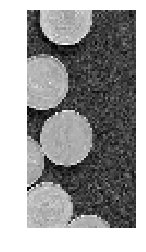

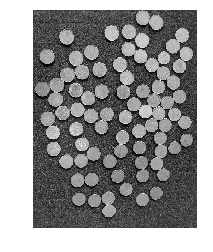

In [57]:
f = im
g1 = np.zeros((3,3))
g1[1,1]=1
plot(np.mean(conv2d(f,g1,k=1)[100:200,250:400],axis=2),**{'cmap':'gray'})
plot(np.mean(conv2d(f,g1,k=1),axis=2),**{'cmap':'gray'})

## Avergage filter (17x17):

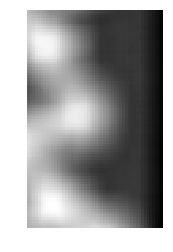

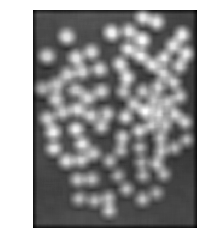

In [58]:
f = im
g2 = np.ones((17,17))*1/(17*17)
plot(np.mean(conv2d(f,g2,k=1)[120:200,250:400],axis=2),**{'cmap':'gray'})
plot(np.mean(conv2d(f,g2,k=1),axis=2),**{'cmap':'gray'})

## Sharpening (17x17)

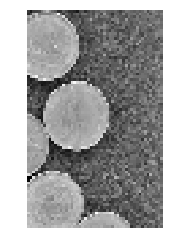

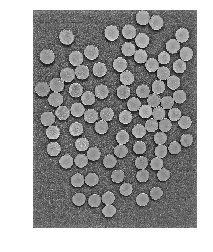

In [59]:
f = im
g1 = np.zeros((17,17))
g1[8,8]=1
g2 = np.ones((17,17))*1/(17*17)
plot(np.mean(conv2d(f,2*g1-g2,k=1),axis=2)[120:200,250:400],**{'cmap':'gray'})
plot(np.mean(conv2d(f,2*g1-g2,k=1),axis=2),**{'cmap':'gray'})

## Gaussian filter

Remove high-frequency components (low-pass filter)

$G_{\sigma}=\frac{1}{2\pi^2}e^{\frac{-(x^2+y^2)}{2\sigma^2}}$

In [60]:
import math
def GaussianFilter(w,h,sigma):
    m = (w-1)/2
    n = (h-1)/2
    G = []
    for i in range(w):
        for j in range(h):
            G.append((1/(2*math.pi*sigma**2))*math.e**(-1*((i-m)**2+(j-n)**2)/(2*sigma**2)))
    
    return np.array(G).reshape(w,h)

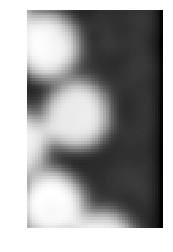

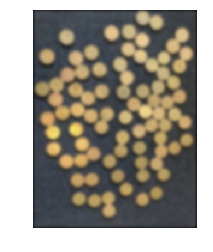

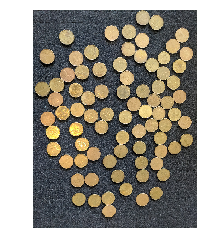

In [61]:
f = im
g3 = GaussianFilter(17,17,3)
plot(np.mean(conv2d(f,g3,k=1)[120:200,250:400],axis=2),**{'cmap':'gray'})
new_im = conv2d(f,g3,k=1)
plot(new_im/255)
plot(im)

## Median filtering

In [62]:
def conv2d_median(f,size=(3,3),k=1,**kwargs):
    w,h = size
    W,H,D = f.shape
        
    x_pad = int(0.5*((W-1)*k-W+w))
    y_pad = int(0.5*((H-1)*k-H+w))
        
    f_pad = np.pad(f,((y_pad,y_pad),(x_pad,x_pad),(0,0)),mode='constant')
    
    new_im = []
    for m in range(int(f_pad.shape[0]-w)+1):
        for n in range(int(f_pad.shape[1]-h+1)):
            new_im.append(np.median(f_pad[m:m+w,n:n+h,:],axis=(0,1)))
            
            
    return np.array(new_im).reshape(W,H,D)

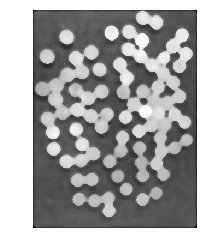

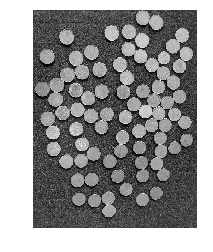

In [65]:
plot(np.mean(conv2d_median(im,size=(11,11),k=1),axis=2),**{'cmap':'gray'})
plot(np.mean(im,axis=2),**{'cmap':'gray'})

# Edges

Identify sudden changes (discontinuities) in an image.

REF: NYU Computer Vision 

### Lets reduce noise (white sparkles) using the median filter

In [67]:
im = conv2d_median(im,size=(11,11),k=1)

<img src='img/lines.png'>

## Image gradient

Taylor series, finite differences. Gradient direction is given by the arctan of grad_y/grad_x. Edge strength os given by the magnitude of the gradient (modulus)

### finite difference in x

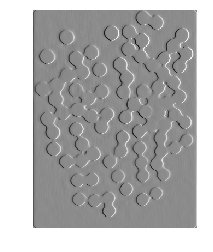

In [70]:
kernel_x= np.array([[0,0,0],[-1,0,1],[0,0,0]])
plot(np.mean(conv2d(im,kernel_x,k=1),axis=2),**{'cmap':'gray'})

### finite difference in y

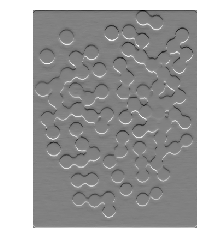

In [72]:
kernel_y= np.array([[0,-1,0],[0,0,0],[0,1,0]])
plot(np.mean(conv2d(im,kernel_y,k=1),axis=2),**{'cmap':'gray'})

### Module

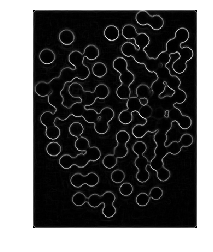

In [75]:
mod = np.sqrt(np.mean(conv2d(im,kernel_y,k=1),axis=2)**2+np.mean(conv2d(im,kernel_x,k=1),axis=2)**2)
plot(mod,**{'cmap':'gray'})

## Other derivative filters:

### Prewitt

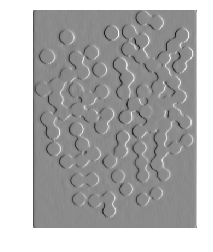

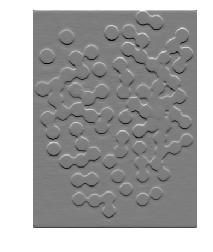

In [76]:
Mx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
My = np.rot90(Mx)

plot(np.mean(conv2d(im,Mx,k=1),axis=2),**{'cmap':'gray'})
plot(np.mean(conv2d(im,My,k=1),axis=2),**{'cmap':'gray'})

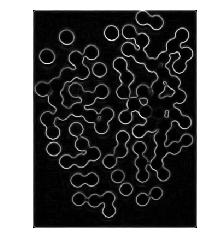

In [77]:
mod = np.sqrt(np.mean(conv2d(im,Mx,k=1),axis=2)**2+np.mean(conv2d(im,My,k=1),axis=2)**2)
plot(mod,**{'cmap':'gray'})

### Sobel

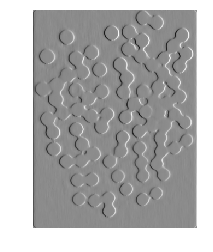

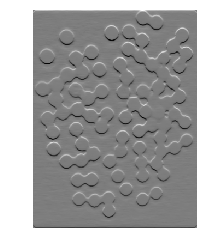

In [78]:
Mx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
My = np.rot90(Mx)

plot(np.mean(conv2d(im,Mx,k=1),axis=2),**{'cmap':'gray'})
plot(np.mean(conv2d(im,My,k=1),axis=2),**{'cmap':'gray'})

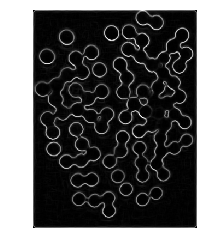

In [79]:
mod = np.sqrt(np.mean(conv2d(im,Mx,k=1),axis=2)**2+np.mean(conv2d(im,My,k=1),axis=2)**2)
plot(mod,**{'cmap':'gray'})

### Roberts

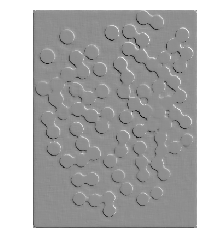

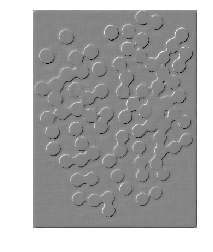

In [80]:
Mx = np.array([[0,0,1],[0,-1,0],[0,0,0]])
My = np.rot90(Mx)

plot(np.mean(conv2d(im,Mx,k=1),axis=2),**{'cmap':'gray'})
plot(np.mean(conv2d(im,My,k=1),axis=2),**{'cmap':'gray'})

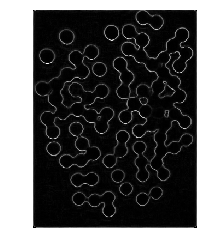

In [81]:
mod = np.sqrt(np.mean(conv2d(im,Mx,k=1),axis=2)**2+np.mean(conv2d(im,My,k=1),axis=2)**2)
plot(mod,**{'cmap':'gray'})

Finite differences filters are sensitive to noise, pixels that look very different from neighbors.
Smoothing aleviates this problem. (For this particular image the median filter was also used to reduce noise caused from the foam's image)

In [82]:
import math
def GaussianFilter(w,h,sigma):
    m = (w-1)/2
    n = (h-1)/2
    G = []
    for i in range(w):
        for j in range(h):
            G.append((1/(2*math.pi*sigma**2))*math.e**(-1*((i-m)**2+(j-n)**2)/(2*sigma**2)))
    
    return np.array(G).reshape(w,h)

Mx= np.array([[0,0,0],[0,-1,1],[0,0,0]])
My= np.array([[0,0,0],[0,-1,0],[0,1,0]])

In [86]:
g = GaussianFilter(3,3,1)

$-\frac{x}{2 \pi \sigma^4}e^{-\frac{(x^2+y^2)}{2 \sigma^2}$

grad_X = $G_{\sigma}=\frac{x}{2\pi\sigma^4}e^{\frac{-(x^2+y^2)}{2\sigma^2}}$

grad_X = $G_{\sigma}=\frac{y}{2\pi\sigma^4}e^{\frac{-(x^2+y^2)}{2\sigma^2}}$

In [87]:
def gradientG(t,w,sigma):
    return (-t/(2*math.pi*sigma**4))*math.e**(-1*(t**2+w**2)/(2*sigma**2))
    
def DOG(w,h,sigma,grad_type='x'):
    m = (w-1)/2
    n = (h-1)/2
    G = []
    for i in range(w):
        for j in range(h):
            if grad_type=='y':
                G.append(gradientG((i-n),(j-n),sigma))
            elif grad_type=='x':
                G.append(gradientG((j-n),(i-n),sigma))
    
    return np.array(G).reshape(w,h)

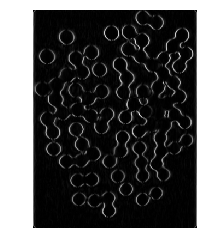

In [93]:
g1 = DOG(3,3,1,'x')
plot(np.mean(np.abs(conv2d(im,g1,k=1)),axis=2),**{'cmap':'gray'})

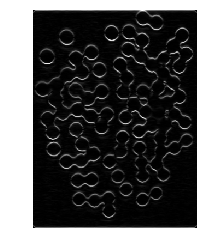

In [94]:
g2 = DOG(3,3,1,'y')
plot(np.mean(np.abs(conv2d(im,g2,k=1)),axis=2),**{'cmap':'gray'})

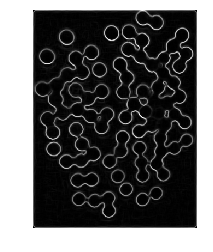

In [95]:
mod = np.sqrt(np.mean(conv2d(im,g1,k=1),axis=2)**2+np.mean(conv2d(im,g2,k=1),axis=2)**2)
plot(mod,**{'cmap':'gray'})